In [ ]:
# This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
# LSTMs are used to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price
# Unlike feed forward neural netwroks, LSTM has feedback connections. Therefore it can process entire sequences of data like a speech or video.
# Widely used for sequence prediction problems, because LSTM are able to store past information which is important, and able to forget irrevelant information

In [ ]:
#Import the libraries
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential         
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#Read the uploaded stock data (18-10-2012 to 18-10-2022)
df = pd.read_csv('AAPL.csv')
#display the data
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-10-18,22.842501,22.930714,22.500000,22.594286,19.374552,476624400
1,2012-10-19,22.537500,22.563213,21.772142,21.780001,18.676304,744086000
2,2012-10-22,21.872143,22.692142,21.812857,22.643929,19.417120,546730800
3,2012-10-23,22.535713,22.639286,21.846430,21.905714,18.784101,707145600
4,2012-10-24,22.194286,22.376785,21.808571,22.029642,18.890368,558527200
...,...,...,...,...,...,...,...
2510,2022-10-11,139.899994,141.350006,138.220001,138.979996,138.979996,77033700
2511,2022-10-12,139.130005,140.360001,138.160004,138.339996,138.339996,70433700
2512,2022-10-13,134.990005,143.589996,134.369995,142.990005,142.990005,113224000
2513,2022-10-14,144.309998,144.520004,138.190002,138.380005,138.380005,88512300


In [ ]:
#Check the type of date column
df['Date']

0       2012-10-18
1       2012-10-19
2       2012-10-22
3       2012-10-23
4       2012-10-24
           ...    
2510    2022-10-11
2511    2022-10-12
2512    2022-10-13
2513    2022-10-14
2514    2022-10-17
Name: Date, Length: 2515, dtype: object

In [ ]:
#Convert object to date
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

#testing the function
datetime_object = str_to_datetime('2012-10-18')
datetime_object

datetime.datetime(2012, 10, 18, 0, 0)

In [ ]:
#Apply this function to all the values in the Date column
df['Date'] = df['Date'].apply(str_to_datetime)
#Check type
df['Date']

0      2012-10-18
1      2012-10-19
2      2012-10-22
3      2012-10-23
4      2012-10-24
          ...    
2510   2022-10-11
2511   2022-10-12
2512   2022-10-13
2513   2022-10-14
2514   2022-10-17
Name: Date, Length: 2515, dtype: datetime64[ns]

In [ ]:
#Replace the first column and make the date column the index
df.index = df.pop('Date')

In [ ]:
#Display the date frame
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-10-18,22.842501,22.930714,22.500000,22.594286,19.374552,476624400
2012-10-19,22.537500,22.563213,21.772142,21.780001,18.676304,744086000
2012-10-22,21.872143,22.692142,21.812857,22.643929,19.417120,546730800
2012-10-23,22.535713,22.639286,21.846430,21.905714,18.784101,707145600
2012-10-24,22.194286,22.376785,21.808571,22.029642,18.890368,558527200
...,...,...,...,...,...,...
2022-10-11,139.899994,141.350006,138.220001,138.979996,138.979996,77033700
2022-10-12,139.130005,140.360001,138.160004,138.339996,138.339996,70433700
2022-10-13,134.990005,143.589996,134.369995,142.990005,142.990005,113224000


In [ ]:
#Number of rows and columns and rows in the dataset
df.shape

(2515, 6)

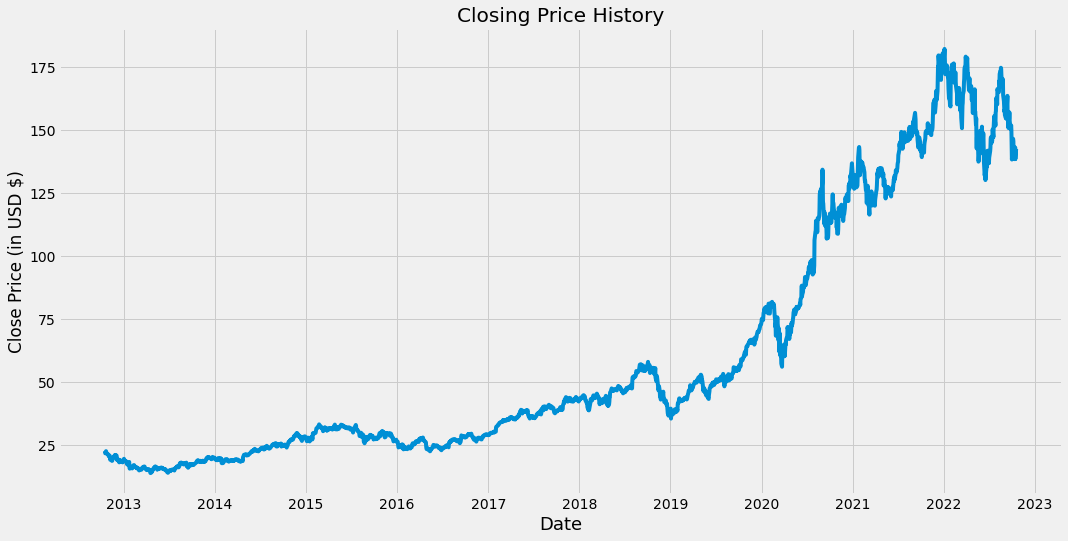

In [ ]:
#Visualize the closing price using matplotlib
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price (in USD $)')
plt.show()

In [ ]:
#Create a new dataframe with only the 'Close column'
data = df.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the LSTM model on (80% training data)
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

2012

In [ ]:
#Display the scaled data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.05144983],
       [0.04660469],
       [0.05174521],
       ...,
       [0.76782452],
       [0.74039425],
       [0.76437342]])

In [ ]:
#Create and scale the training data set
train_data = scaled_data[0:training_data_len, :]

#Split the data into x_train and y_train data sets
#x_train dataset will contain independent training features, y_train will be the dependent/target feature
x_train = []
y_train = []


for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])   
  y_train.append(train_data[i, 0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()




[array([0.05144983, 0.04660469, 0.05174521, 0.04735271, 0.0480901 ,
       0.04654093, 0.04536365, 0.0435191 , 0.04377836, 0.03958349,
       0.04124529, 0.04086915, 0.03558838, 0.03128513, 0.03326356,
       0.03236466, 0.03237954, 0.03110025, 0.02870743, 0.0291452 ,
       0.03723105, 0.03620676, 0.03637465, 0.0384572 , 0.0422887 ,
       0.04127929, 0.04088828, 0.04225256, 0.04138554, 0.04157891,
       0.03938161, 0.03150614, 0.03330182, 0.03032885, 0.02959997,
       0.03205866, 0.03155076, 0.02957233, 0.02534346, 0.02726451,
       0.03046699, 0.02885406, 0.02788079, 0.02737078, 0.02754927,
       0.0260256 , 0.02646337, 0.02530096, 0.03009934, 0.03368219,
       0.03220953, 0.02900069, 0.02834192, 0.02864155, 0.02689688,
       0.02825905, 0.02757691, 0.02363492, 0.02027095, 0.02455719])]
[0.023832539199183017]

[array([0.05144983, 0.04660469, 0.05174521, 0.04735271, 0.0480901 ,
       0.04654093, 0.04536365, 0.0435191 , 0.04377836, 0.03958349,
       0.04124529, 0.04086915, 0.0

In [ ]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data for LSTM
#LSTM expects the input to be 3-dimensional (#samples, #timesteps, #features)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1952, 60, 1)

In [ ]:
#Build the LSTM model
model = Sequential()

#The first argument indicates the number of neurons
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences = False))  
#Return sequences is false, because we will not be using any more LSTM layers for our model
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#Compile the model with parameters
#Optimizer is used to improve upon the loss function
#Loss function is used to tell how well the model did on training data
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
#Train the model
#epochs is the number of iterations when the entire dataset is passed forward and backward through a NN
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

1952/1952 [==============================] - 50s 24ms/step - loss: 5.5412e-04


In [ ]:
#Create the test data set
#Create a new array containing scaled values from index 1952 to 2515
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test (the values we want to predict)
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [ ]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
#Reshape the data to 3 dimensional for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #unscaling

16/16 [==============================] - 1s 15ms/step


In [ ]:
#Model evaluation using Root Mean Square Error (RMSE)
#Lower values of RMSE indicate a better fit
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

4.52219608085513

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


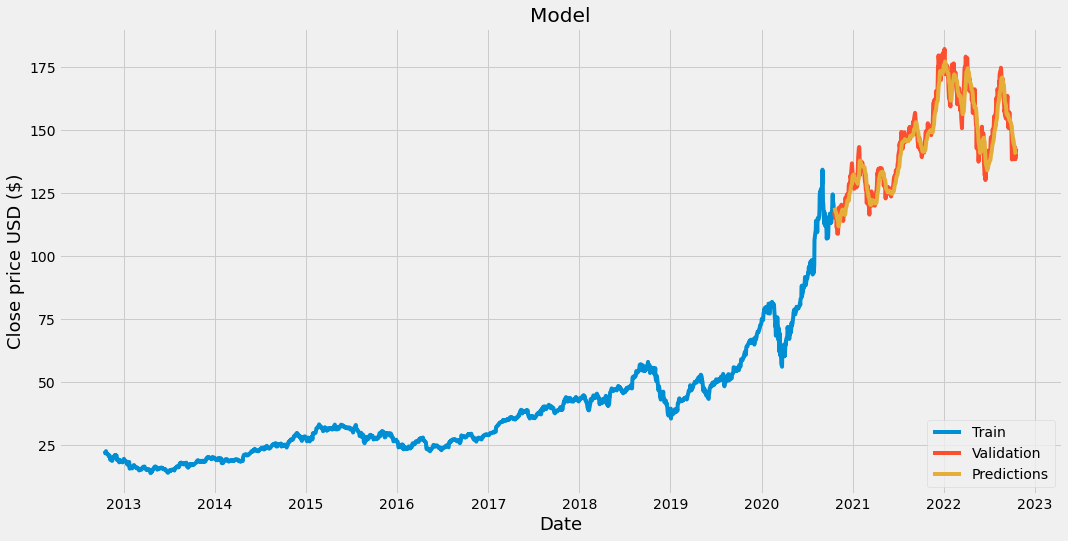

In [ ]:
#Plot the data
train = data[0:training_data_len]
valid_data = data[training_data_len:]
valid_data['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid_data[['Close', 'Predictions']])
plt.legend(['Train','Validation','Predictions'], loc="lower right")
plt.show()

In [ ]:
#Show the validation and predicted prices
valid_data

,Close,Predictions
Date,,
2020-10-19,115.980003,119.090454
2020-10-20,117.510002,118.873550
2020-10-21,116.870003,118.579742
2020-10-22,115.750000,118.184471
2020-10-23,115.040001,117.651932
...,...,...
2022-10-11,138.979996,142.971909
2022-10-12,138.339996,142.039001
2022-10-13,142.990005,141.083588
